# Project 2 - metrics

Authors: Agata Kaczmarek, Władysław Olejnik, Mateusz Stączek

## Implementations

In [1]:
# import hicstraw

# hic = hicstraw.HiCFile(HIC_FILE)
# lengths_of_chromosomes = {c.name: c.length for c in hic.getChromosomes()}
lengths_of_chromosomes = {'ALL': 3095693,
                            '1': 249250621,
                            '2': 243199373,
                            '3': 198022430,
                            '4': 191154276,
                            '5': 180915260,
                            '6': 171115067,
                            '7': 159138663,
                            '8': 146364022,
                            '9': 141213431,
                           '10': 135534747,
                           '11': 135006516,
                           '12': 133851895,
                           '13': 115169878,
                           '14': 107349540,
                           '15': 102531392,
                           '16': 90354753,
                           '17': 81195210,
                           '18': 78077248,
                           '19': 59128983,
                           '20': 63025520,
                           '21': 48129895,
                           '22': 51304566,
                            'X': 155270560,
                            'Y': 59373566,
                            'M': 16571}

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm

def read_arrowhead_bedpe(path_to_file):
    return pd.read_csv(path_to_file, sep="\t", usecols=[0,1,2],
                       skiprows=2, names=["chr", "start", "end"])

def read_communities_csv(path_to_file):
    return pd.read_csv(path_to_file, index_col=0, skiprows=1, names=["chr", "start", "end"], dtype={"chr": str})

def get_1d_diagonal_with_zeros_and_ones(df, length):
    was_tad_present_diagonal = np.zeros(length)
    for _, tad in df.iterrows():
        was_tad_present_diagonal[tad['start']:tad['end']] = 1
    return was_tad_present_diagonal

def compute_confusion_matrix(df_arrowhead, df_communities, lengths_of_chromosomes):
    confusion_matrix = np.zeros((2, 2), dtype=np.int64)

    # compare each chromosome separately
    pbar = tqdm(lengths_of_chromosomes.items())
    for chromosome, length in pbar:
        pbar.set_description(f'Analyzing chromosome {chromosome} of length {length//1000000} Mb.')
        tads_arrowhead_diagonal = get_1d_diagonal_with_zeros_and_ones(df_arrowhead[df_arrowhead['chr'] == chromosome], length)
        tads_communities_diagonal = get_1d_diagonal_with_zeros_and_ones(df_communities[df_communities['chr'] == chromosome], length)

        confusion_matrix[0, 0] += np.sum(tads_arrowhead_diagonal * tads_communities_diagonal) # true positive
        confusion_matrix[0, 1] += np.sum(tads_arrowhead_diagonal * (1 - tads_communities_diagonal)) # false negative
        confusion_matrix[1, 0] += np.sum((1 - tads_arrowhead_diagonal) * tads_communities_diagonal) # false positive
        confusion_matrix[1, 1] += np.sum((1 - tads_arrowhead_diagonal) * (1 - tads_communities_diagonal)) # true negative

    confusion_matrix_df = pd.DataFrame(confusion_matrix, columns=['Predicted TAD', 'Predicted not TAD'], index=['Arrowhead TAD', 'Arrowhead not TAD'])

    return confusion_matrix_df

def compute_other_metrics(confusion_matrix):
    TP = confusion_matrix.iloc[0, 0]
    FN = confusion_matrix.iloc[0, 1]
    FP = confusion_matrix.iloc[1, 0]
    TN = confusion_matrix.iloc[1, 1]

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)
    balanced_accuracy = (recall + TN / (TN + FP)) / 2
    jaccard_index = TP/(TP+FN+FP)

    return pd.DataFrame([[round(v, 4) for v in [balanced_accuracy, jaccard_index]]],
                         columns=['Balanced accuracy', 'Jaccard index'])

New Metric algorithm:
- for each chromosome:
    - create a vector of ones and zeros, with ones where TADs were detected
    - multiply element-wise the vectors from 2 sources: our results and arrowhead results
    - for each of the source files:
        - for each community:
            - calculate the fraction of ones from this community that are in the product vector
            - it add to the current sum of products
        - divide the total sum of products by the number of communities in the source file

This way we obtain a metric that calculates the average fraction of elements from each community that are also in another results file.

In [3]:
def compute_new_metric(df_arrowhead, df_communities, lengths_of_chromosomes):
    list_results_base_communities=[0 for _ in range(len(lengths_of_chromosomes.items()))]#our as base, saved sum
    sum_communities=0
    list_results_base_arrowhead=[0 for _ in range(len(lengths_of_chromosomes.items()))]#arrowhead as base
    sum_arrowhead=0
    num_chromosome=0

    # compare each chromosome separately
    pbar = tqdm(lengths_of_chromosomes.items())
    for chromosome, length in pbar:
        pbar.set_description(f'Analyzing chromosome {chromosome} of length {length//1000000} Mb.')
        tads_arrowhead_diagonal = get_1d_diagonal_with_zeros_and_ones(df_arrowhead[df_arrowhead['chr'] == chromosome], length)
        tads_communities_diagonal = get_1d_diagonal_with_zeros_and_ones(df_communities[df_communities['chr'] == chromosome], length)

        merged_diagonals=tads_arrowhead_diagonal * tads_communities_diagonal

        #dla każdego kwadratu policzyć ile się pokrywa i dodać do listy
        for i_community in range(df_communities[df_communities['chr'] == chromosome].shape[0]):
          start_community=df_communities[df_communities['chr'] == chromosome]['start'].iloc[i_community]
          end_community=df_communities[df_communities['chr'] == chromosome]['end'].iloc[i_community]
          sum_of_merged=np.sum(merged_diagonals[start_community:end_community])/(end_community-start_community)
          list_results_base_communities[num_chromosome]+=sum_of_merged
          sum_communities+=sum_of_merged
        if df_communities[df_communities['chr'] == chromosome].shape[0]!=0:
           list_results_base_communities[num_chromosome]=np.divide(list_results_base_communities[num_chromosome],df_communities[df_communities['chr'] == chromosome].shape[0])

        for i_arrowhead in range(df_arrowhead[df_arrowhead['chr'] == chromosome].shape[0]):
          start_arrowhead=df_arrowhead[df_arrowhead['chr'] == chromosome]['start'].iloc[i_arrowhead]
          end_arrowhead=df_arrowhead[df_arrowhead['chr'] == chromosome]['end'].iloc[i_arrowhead]
          sum_of_merged=np.sum(merged_diagonals[start_arrowhead:end_arrowhead])/(end_arrowhead-start_arrowhead)
          list_results_base_arrowhead[num_chromosome]+=sum_of_merged
          sum_arrowhead+=sum_of_merged
        if df_arrowhead[df_arrowhead['chr'] == chromosome].shape[0]!=0:
          list_results_base_arrowhead[num_chromosome]=np.divide(list_results_base_arrowhead[num_chromosome],df_arrowhead[df_arrowhead['chr'] == chromosome].shape[0])
        
        num_chromosome+=1
    return list_results_base_communities, list_results_base_arrowhead, sum_communities, sum_arrowhead

## Loading data

### Loading our results

We analyzed 3 files and for each, saved the results to a CSV:
 - `GSE226216_HMEC_Res10_20_40_100_500kb` - 575MB,
 - `GSE226216_Huh1_Inter_Intra_Res10_20_40_100_500kb` - 573MB,
 - `GSE226216_SNU449_Inter_Intra_Res10_20_40_100_500kb` - 584MB.
 
https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE226216 - Hi-C sequencing
Limited resolutions to 10kb, 20kb, 40kb, 100kb and 500kb (fine for us). 

This is how to download original files:

In [4]:
# !wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE226nnn/GSE226216/suppl/GSE226216%5FHMEC%5FRes10%5F20%5F40%5F100%5F500kb.hic
# !wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE226nnn/GSE226216/suppl/GSE226216%5FHuh1%5FInter%5FIntra%5FRes10%5F20%5F40%5F100%5F500kb.hic
# !wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE226nnn/GSE226216/suppl/GSE226216%5FSNU449%5FInter%5FIntra%5FRes10%5F20%5F40%5F100%5F500kb.hic

And here we load CSVs with found TADs:

In [5]:
import pandas as pd

filenames_ours = {
    "GSE226216_HMEC_Res10_20_40_100_500kb"               : "processed_data/results_normVC_SQRT_erase2_res1_zt1_GSE226216_HMEC_Res10_20_40_100_500kb.csv",
    "GSE226216_Huh1_Inter_Intra_Res10_20_40_100_500kb"   : "processed_data/results_normVC_SQRT_erase2_res1_zt1_GSE226216_Huh1_Inter_Intra_Res10_20_40_100_500kb.csv",
    "GSE226216_SNU449_Inter_Intra_Res10_20_40_100_500kb" : "processed_data/results_normVC_SQRT_erase2_res1_zt1_GSE226216_SNU449_Inter_Intra_Res10_20_40_100_500kb.csv"
}

# print first dataframe
dfs_ours = {key: read_communities_csv(value) for key, value in filenames_ours.items()}
dfs_ours["GSE226216_HMEC_Res10_20_40_100_500kb"].head()

,chr,start,end
0,1,182910000,183230000
1,1,0,320000
2,1,233160000,233520000
3,1,102510000,102750000
4,1,345720000,346000000


### Loading results from Arrowhead

Arrowhead results were obtained with default settings of 10kb resolution.

In [6]:
import pandas as pd

filenames_arrowhead = {
"GSE226216_HMEC_Res10_20_40_100_500kb"                   : "processed_data/GSE226216_HMEC_Res10_20_40_100_500kb.hic___10000_blocks.bedpe",
    "GSE226216_Huh1_Inter_Intra_Res10_20_40_100_500kb"   : "processed_data/GSE226216_Huh1_Inter_Intra_Res10_20_40_100_500kb.hic___10000_blocks.bedpe",
    "GSE226216_SNU449_Inter_Intra_Res10_20_40_100_500kb" : "processed_data/GSE226216_SNU449_Inter_Intra_Res10_20_40_100_500kb.hic___10000_blocks.bedpe"
}

# print first dataframe
dfs_arrowhead = {key: read_arrowhead_bedpe(value) for key, value in filenames_arrowhead.items()}
dfs_arrowhead["GSE226216_HMEC_Res10_20_40_100_500kb"].head()

,chr,start,end
0,10,132000000,133370000
1,10,57410000,59050000
2,10,37180000,39150000
3,10,46900000,47750000
4,10,81270000,82010000


## Computing metrics

In [8]:
metrics = []
for (source_file_ours, df_ours), (source_file_arrowhead, df_arrowhead) in zip(dfs_ours.items(), dfs_arrowhead.items()):
    print("Computing Confusion matrix - Analyzing ours", source_file_ours, "with arrowhead", source_file_arrowhead)
    lengths_of_chromosomes = {k: v for k, v in lengths_of_chromosomes.items() if k in df_arrowhead['chr'].unique()}
    confusion_matrix = compute_confusion_matrix(df_arrowhead, df_ours, lengths_of_chromosomes)
    other_metrics = compute_other_metrics(confusion_matrix)
    print("Computing new metric")
    list_results_base_communities, list_results_base_arrowhead, sum_communities, sum_arrowhead = compute_new_metric(df_arrowhead, df_ours, lengths_of_chromosomes)
    
    metrics.append({
        "Filename" : source_file_ours,
        "Balanced accuracy" : other_metrics["Balanced accuracy"].values[0],
        "Jaccard index" : other_metrics["Jaccard index"].values[0],
        "Average match for our communities" : sum_communities / len(df_ours),
        "Average match for arrowhead" : sum_arrowhead / len(df_arrowhead),
    })

Computing Confusion matrix - Analyzing ours GSE226216_HMEC_Res10_20_40_100_500kb with arrowhead GSE226216_HMEC_Res10_20_40_100_500kb


Analyzing chromosome X of length 155 Mb.: 100%|██████████| 23/23 [02:12<00:00,  5.77s/it] 


Computing new metric


Analyzing chromosome X of length 155 Mb.: 100%|██████████| 23/23 [00:36<00:00,  1.57s/it] 


Computing Confusion matrix - Analyzing ours GSE226216_Huh1_Inter_Intra_Res10_20_40_100_500kb with arrowhead GSE226216_Huh1_Inter_Intra_Res10_20_40_100_500kb


Analyzing chromosome X of length 155 Mb.: 100%|██████████| 23/23 [02:21<00:00,  6.15s/it] 


Computing new metric


Analyzing chromosome X of length 155 Mb.: 100%|██████████| 23/23 [00:46<00:00,  2.03s/it] 


Computing Confusion matrix - Analyzing ours GSE226216_SNU449_Inter_Intra_Res10_20_40_100_500kb with arrowhead GSE226216_SNU449_Inter_Intra_Res10_20_40_100_500kb


Analyzing chromosome X of length 155 Mb.: 100%|██████████| 22/22 [02:15<00:00,  6.18s/it] 


Computing new metric


Analyzing chromosome X of length 155 Mb.: 100%|██████████| 22/22 [00:45<00:00,  2.08s/it] 


In [9]:
mertics_df = pd.DataFrame(metrics)
mertics_df

,Filename,Balanced accuracy,Jaccard index,Average match for our communities,Average match for arrowhead
0,GSE226216_HMEC_Res10_20_40_100_500kb,0.4982,0.0352,0.142463,0.034653
1,GSE226216_Huh1_Inter_Intra_Res10_20_40_100_500kb,0.4987,0.0375,0.107103,0.040056
2,GSE226216_SNU449_Inter_Intra_Res10_20_40_100_5...,0.4988,0.0391,0.110612,0.042513


In [10]:
mertics_df.to_csv("results/metrics.csv", index=False)

In [11]:
import matplotlib.pyplot as plt

def plot_histograms(filename, df_ours, df_arrowhead):

    df_ours['size'] = df_ours['end'] - df_ours['start']
    df_arrowhead['size'] = df_arrowhead['end'] - df_arrowhead['start']

    plt.figure(figsize=(5,3))
    plt.hist(df_ours[(df_ours['size'] > 0) & (df_ours['size'] < 0.6*10**6)]['size']/10**6, range=(0, 0.6), bins=25)
    plt.hist(df_arrowhead[(df_arrowhead['size'] > 0) & (df_arrowhead['size'] < 0.6*10**6)]['size']/10**6, range=(0, 0.6), bins=25, alpha=0.7)
    plt.xlim(0, 0.6)
    plt.xlabel('TAD size (Mb)')
    plt.ylabel('Number of TADs')
    plt.legend(['Communities (ours)', 'Arrowhead (ground truth)'])
    plt.title(f"Histogram of detected TAD sizes\nDataset: {filename}")
    plt.savefig(f"results/histogram_{filename}.png")
    plt.show()

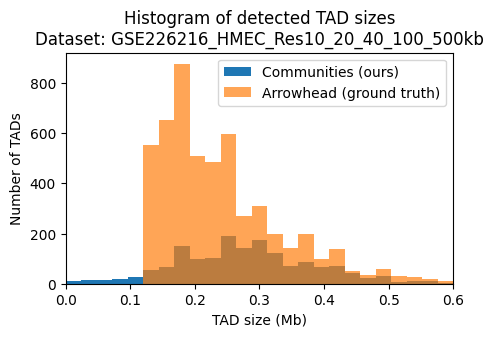

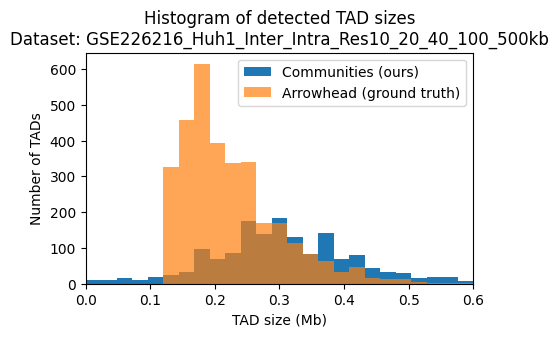

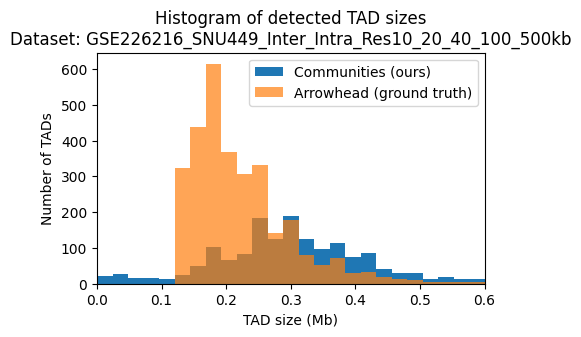

In [15]:
for (source_file_ours, df_ours), (source_file_arrowhead, df_arrowhead) in zip(dfs_ours.items(), dfs_arrowhead.items()):
    plot_histograms(source_file_ours, df_ours, df_arrowhead)

## Conclusions

Based on the results, our algorithm is consistent in marking fewer TADs than Arrowhead. This is visible in the histograms. Based on other metrics, we can see that our algorithm detected much fewer TADs than Arrowhead. We believe, that it would be possible to tune our algorithm in order to better match the distribution of the sizes of TADs. Furthermore, Arrowhead is not perfect either, but we treat is a ground truth in this case.